# Model Comparison and Final Forecasts

This notebook compares all forecasting models and generates final production forecasts.

## Models Compared
1. **Baselines**: Naive, Seasonal Naive, Moving Average (3, 6), Linear Trend
2. **Prophet**: Facebook Prophet with Swiss holidays and custom seasonalities
3. **SARIMAX**: Seasonal ARIMA (2,1,2) × (1,1,1,12)
4. **XGBoost**: Gradient boosting with engineered features

## Evaluation Metrics
- **MAPE** (Mean Absolute Percentage Error) - Primary metric
- **MAE** (Mean Absolute Error)
- **RMSE** (Root Mean Square Error)

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## Section 1: Load All Model Metrics

In [2]:
# Load performance metrics from all models
metrics_dir = Path('../data/processed')

model_files = [
    ('baseline_metrics.csv', 'Baseline'),
    ('prophet_metrics.csv', 'Prophet'),
    ('sarimax_metrics.csv', 'SARIMAX'),
    ('xgboost_metrics.csv', 'XGBoost')
]

all_metrics = []

for filename, model_family in model_files:
    filepath = metrics_dir / filename
    if filepath.exists():
        df = pd.read_csv(filepath)
        df['model_family'] = model_family
        all_metrics.append(df)
        print(f"✓ Loaded {filename}: {len(df)} records")
    else:
        print(f"⚠️  Missing {filename}")

# Combine all metrics
if len(all_metrics) > 0:
    metrics_df = pd.concat(all_metrics, ignore_index=True)
    print(f"\nTotal model evaluations: {len(metrics_df)}")
    print(f"Models: {metrics_df['model'].unique()}")
    print(f"Metrics: {metrics_df['metric'].unique()}")
else:
    print("\n❌ No model metrics found. Run notebooks 09-12 first.")

✓ Loaded baseline_metrics.csv: 60 records
✓ Loaded prophet_metrics.csv: 10 records
✓ Loaded sarimax_metrics.csv: 10 records
✓ Loaded xgboost_metrics.csv: 10 records

Total model evaluations: 90
Models: ['Naive' 'Seasonal Naive' 'MA-3' 'MA-6' 'Linear Trend'
 'Linear Distribution (Current Method)' 'Prophet' 'SARIMAX' 'XGBoost']
Metrics: ['total_orders' 'total_km_billed' 'total_km_actual' 'total_tours'
 'total_drivers' 'revenue_total' 'external_drivers' 'vehicle_km_cost'
 'vehicle_time_cost' 'total_vehicle_cost']


## Section 2: Model Rankings by MAPE

Rank all models for each target metric.

In [3]:
print("Model Rankings by MAPE")
print("="*80)

target_metrics = metrics_df['metric'].unique()

best_models = {}

for target_metric in target_metrics:
    print(f"\n{target_metric.upper()}:")
    print("-"*80)
    
    # Filter for this metric and sort by MAPE
    metric_df = metrics_df[metrics_df['metric'] == target_metric].sort_values('MAPE')
    
    # Display top 5
    print(f"{'Rank':<6} {'Model':<20} {'MAPE':>10} {'MAE':>12} {'RMSE':>12}")
    print("-"*65)
    
    for i, row in enumerate(metric_df.head(5).itertuples(), 1):
        symbol = "🏆" if i == 1 else f"  {i}."
        print(f"{symbol:<6} {row.model:<20} {row.MAPE:>9.2f}% {row.MAE:>12,.0f} {row.RMSE:>12,.0f}")
    
    # Store best model
    best = metric_df.iloc[0]
    best_models[target_metric] = best['model']
    
print("\n" + "="*80)
print("BEST MODELS BY METRIC:")
print("="*80)
for metric, model in best_models.items():
    mape = metrics_df[(metrics_df['metric'] == metric) & (metrics_df['model'] == model)]['MAPE'].values[0]
    print(f"  • {metric}: {model} (MAPE: {mape:.2f}%)")

Model Rankings by MAPE

TOTAL_ORDERS:
--------------------------------------------------------------------------------
Rank   Model                      MAPE          MAE         RMSE
-----------------------------------------------------------------
🏆      XGBoost                   2.50%        3,578        4,633
  2.   Seasonal Naive            2.95%        4,190        5,239
  3.   Linear Distribution (Current Method)      4.17%        5,985        7,288
  4.   Linear Trend              4.23%        6,097        7,791
  5.   MA-3                      4.34%        6,242        7,826

TOTAL_KM_BILLED:
--------------------------------------------------------------------------------
Rank   Model                      MAPE          MAE         RMSE
-----------------------------------------------------------------
🏆      XGBoost                   2.64%      232,754      267,945
  2.   Seasonal Naive            2.89%      253,156      288,357
  3.   Linear Distribution (Current Method)      

## Section 3: Visualization - Model Comparison

Create comparison charts for all models.

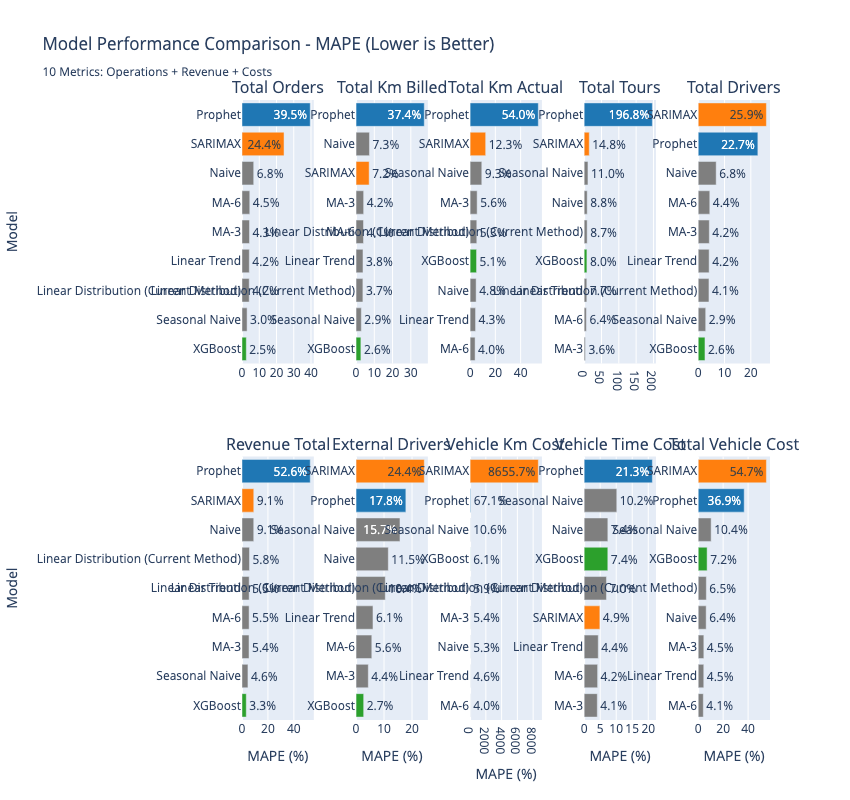

✓ Saved: results/model_comparison_mape.html
  Layout: 2 rows × 5 columns = 10 metrics


In [4]:
# Create MAPE comparison chart - Updated for 10 metrics (2 rows × 5 cols)
num_metrics = len(target_metrics)
num_cols = 5
num_rows = (num_metrics + num_cols - 1) // num_cols  # Ceiling division

fig = make_subplots(
    rows=num_rows, cols=num_cols,
    subplot_titles=[m.replace('_', ' ').title() for m in target_metrics],
    horizontal_spacing=0.08,
    vertical_spacing=0.15
)

colors = {
    'Baseline': '#7f7f7f',
    'Prophet': '#1f77b4',
    'SARIMAX': '#ff7f0e',
    'XGBoost': '#2ca02c'
}

for idx, target_metric in enumerate(target_metrics):
    row = (idx // num_cols) + 1
    col = (idx % num_cols) + 1
    
    metric_df = metrics_df[metrics_df['metric'] == target_metric].sort_values('MAPE')
    
    fig.add_trace(
        go.Bar(
            y=metric_df['model'],
            x=metric_df['MAPE'],
            orientation='h',
            marker=dict(
                color=[colors.get(mf, '#999999') for mf in metric_df['model_family']]
            ),
            showlegend=False,
            text=metric_df['MAPE'].apply(lambda x: f"{x:.1f}%"),
            textposition='auto'
        ),
        row=row, col=col
    )

# Update axes labels
for i in range(1, num_cols + 1):
    fig.update_xaxes(title_text="MAPE (%)", row=num_rows, col=i)

fig.update_yaxes(title_text="Model", row=1, col=1)
if num_rows > 1:
    fig.update_yaxes(title_text="Model", row=2, col=1)

fig.update_layout(
    title_text="Model Performance Comparison - MAPE (Lower is Better)<br><sub>10 Metrics: Operations + Revenue + Costs</sub>",
    height=400 * num_rows,  # Adjust height based on number of rows
    showlegend=False
)

fig.show()

# Save
results_dir = Path('../results')
results_dir.mkdir(exist_ok=True)
fig.write_html(results_dir / 'model_comparison_mape.html')
print(f"✓ Saved: results/model_comparison_mape.html")
print(f"  Layout: {num_rows} rows × {num_cols} columns = {num_metrics} metrics")

## Section 4: Load Forecast Data for Visualization

Compare actual vs predicted values for best models.

In [5]:
# Load actual monthly data
df_actual = pd.read_csv(metrics_dir / 'monthly_aggregated_full_company.csv')
df_actual['date'] = pd.to_datetime(df_actual['date'])
print(f"✓ Loaded actual data: {len(df_actual)} months")
print(f"  Date range: {df_actual['date'].min()} to {df_actual['date'].max()}")
print(f"  Columns: {list(df_actual.columns)}")

✓ Loaded actual data: 36 months
  Date range: 2022-01-01 00:00:00 to 2024-12-01 00:00:00
  Columns: ['year_month', 'total_orders', 'external_drivers', 'internal_drivers', 'revenue_total', 'total_km_billed', 'total_km_actual', 'total_tours', 'vehicle_km_cost', 'vehicle_time_cost', 'total_vehicle_cost', 'Delivery', 'Leergut', 'Pickup/Multi-leg', 'Retoure/Abholung', 'date', 'total_drivers', 'km_per_order', 'km_efficiency', 'revenue_per_order', 'cost_per_order', 'profit_margin', 'month', 'year']


In [6]:
# Split train/val
train_end = '2024-06-30'
val_start = '2024-07-01'
val_end = '2024-12-31'

train_df = df_actual[df_actual['date'] <= train_end]
val_df = df_actual[(df_actual['date'] >= val_start) & (df_actual['date'] <= val_end)]

print(f"Training: {len(train_df)} months")
print(f"Validation: {len(val_df)} months")

# Load forecasts from best models
forecasts = {}

for metric, best_model in best_models.items():
    # Determine which file to load based on model name
    if 'Prophet' in best_model:
        forecast_file = 'prophet_forecast_validation.csv'
    elif 'SARIMAX' in best_model:
        forecast_file = 'sarimax_forecast_validation.csv'
    elif 'XGBoost' in best_model:
        forecast_file = 'xgboost_forecast_validation.csv'
    else:
        # Baseline model
        model_name_clean = best_model.lower().replace(' ', '_').replace('-', '')
        forecast_file = f'baseline_forecast_{model_name_clean}.csv'
    
    forecast_path = metrics_dir / forecast_file
    
    if forecast_path.exists():
        df_forecast = pd.read_csv(forecast_path)
        forecasts[metric] = {
            'model': best_model,
            'data': df_forecast
        }
        print(f"✓ Loaded forecast for {metric}: {best_model}")
    else:
        print(f"⚠️  Forecast file not found: {forecast_file}")

Training: 30 months
Validation: 6 months
✓ Loaded forecast for total_orders: XGBoost
✓ Loaded forecast for total_km_billed: XGBoost
✓ Loaded forecast for total_km_actual: MA-6
✓ Loaded forecast for total_tours: MA-3
✓ Loaded forecast for total_drivers: XGBoost
✓ Loaded forecast for revenue_total: XGBoost
✓ Loaded forecast for external_drivers: XGBoost
✓ Loaded forecast for vehicle_km_cost: MA-6
✓ Loaded forecast for vehicle_time_cost: MA-3
✓ Loaded forecast for total_vehicle_cost: MA-6


## Section 5: Best Model Forecasts Visualization

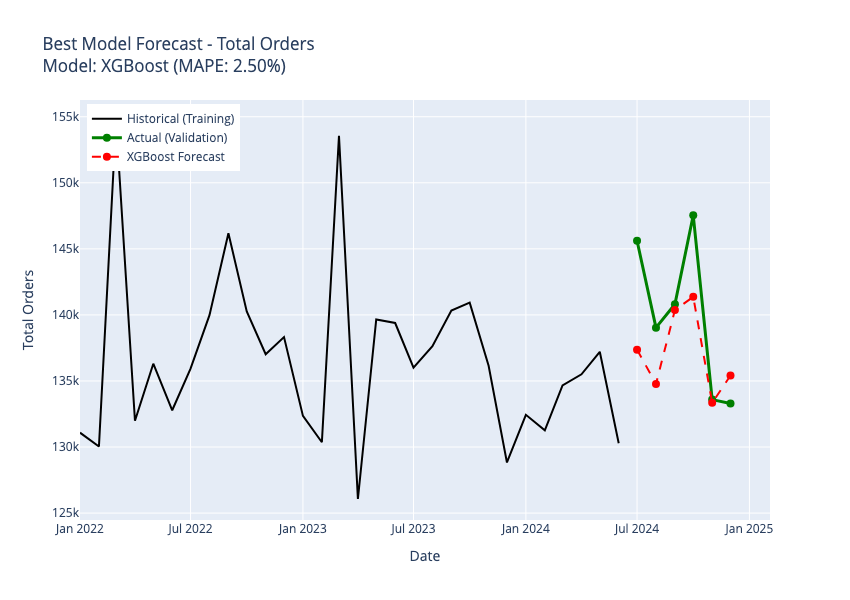

✓ Saved: results/best_model_forecast_total_orders.html


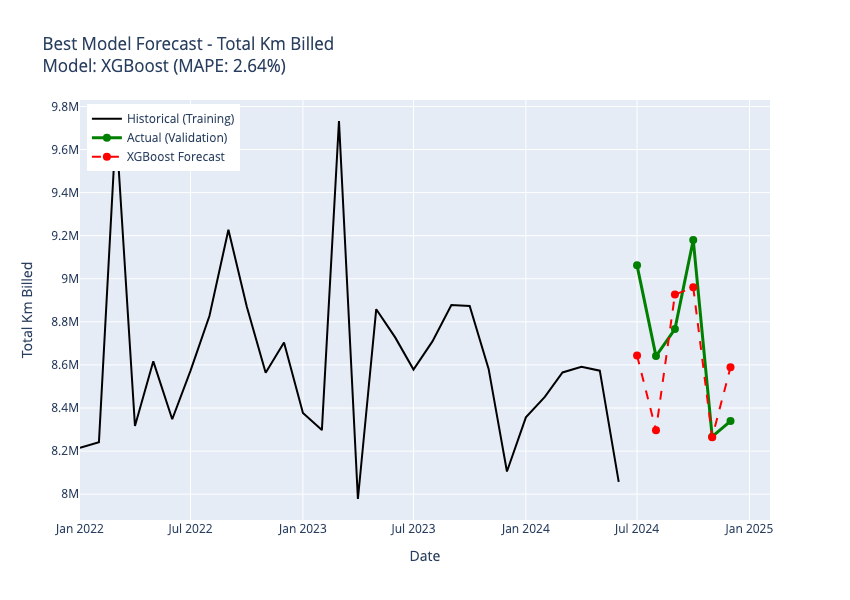

✓ Saved: results/best_model_forecast_total_km_billed.html


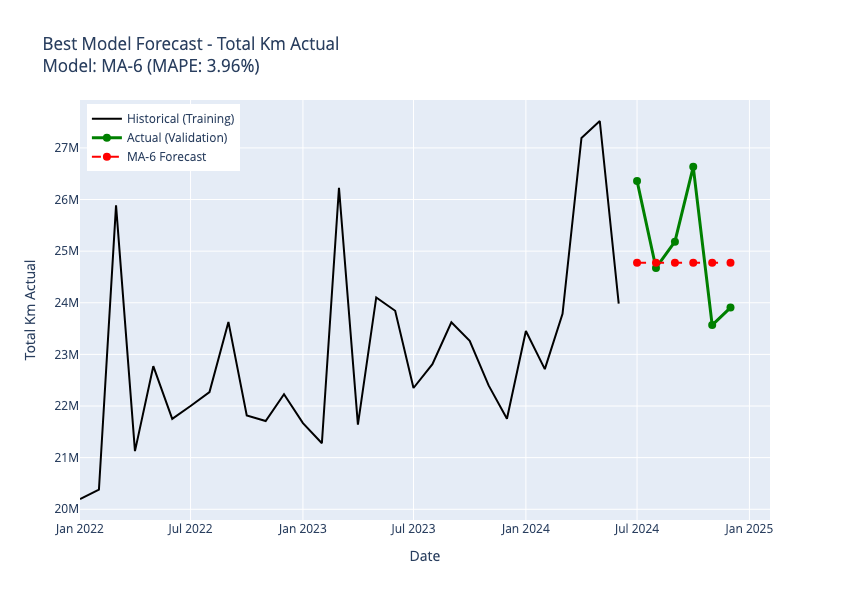

✓ Saved: results/best_model_forecast_total_km_actual.html


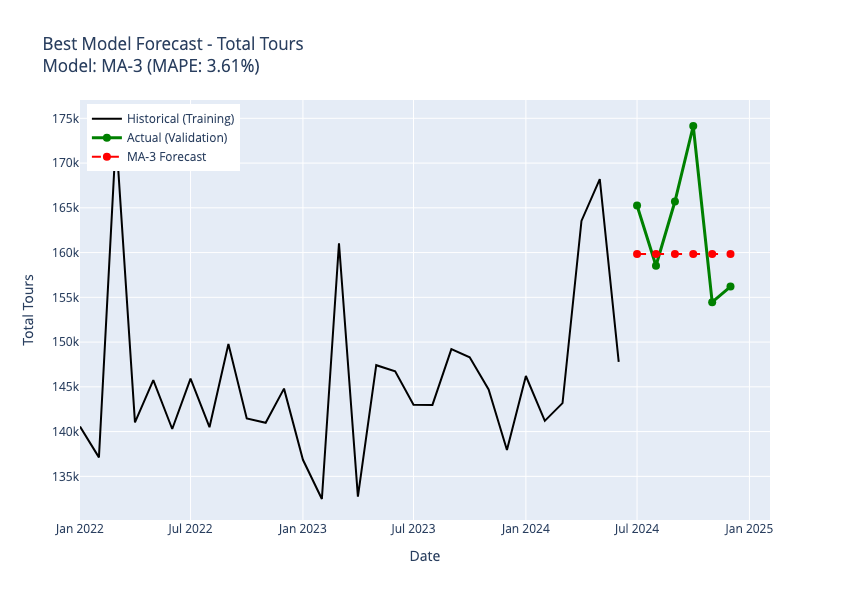

✓ Saved: results/best_model_forecast_total_tours.html


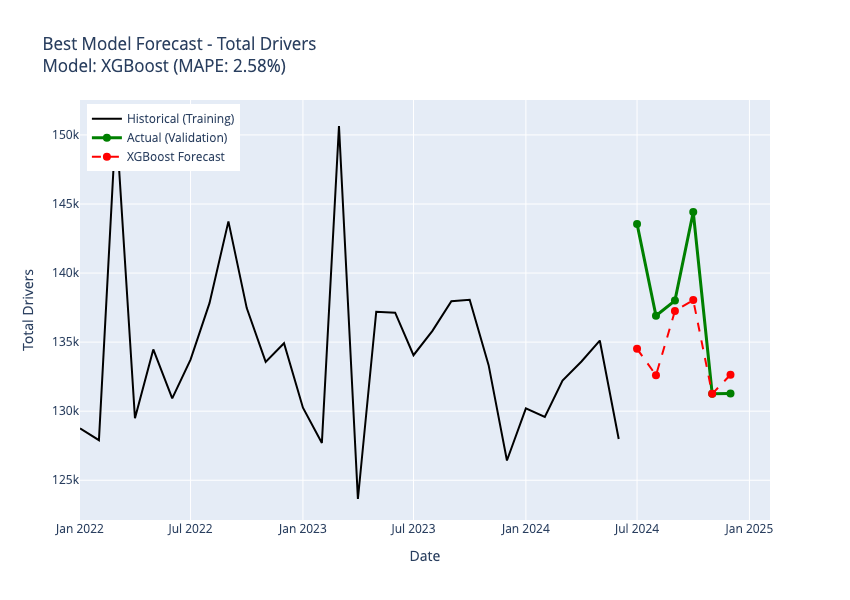

✓ Saved: results/best_model_forecast_total_drivers.html


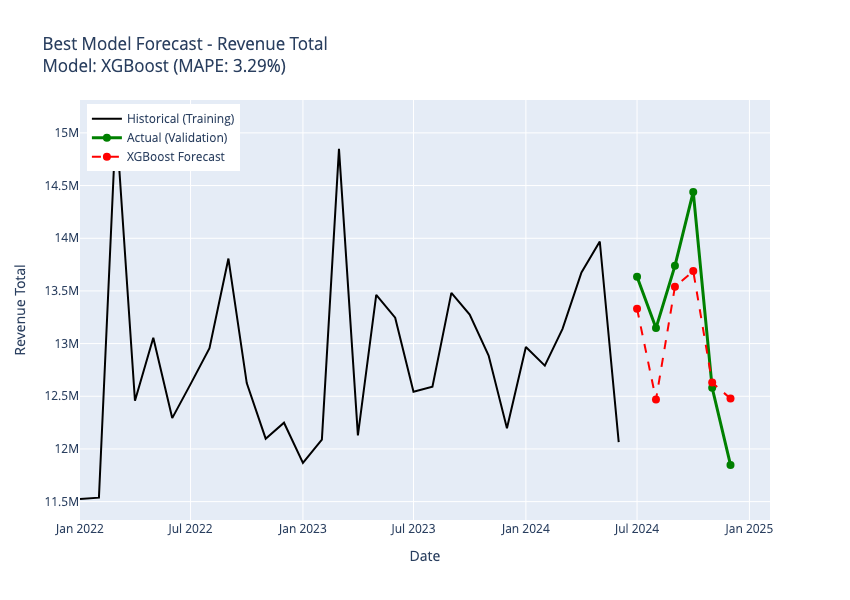

✓ Saved: results/best_model_forecast_revenue_total.html


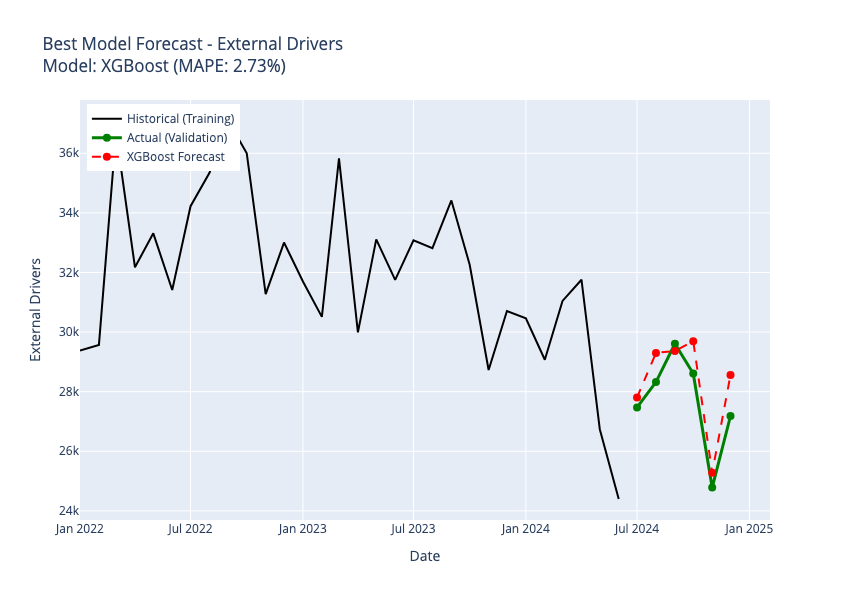

✓ Saved: results/best_model_forecast_external_drivers.html


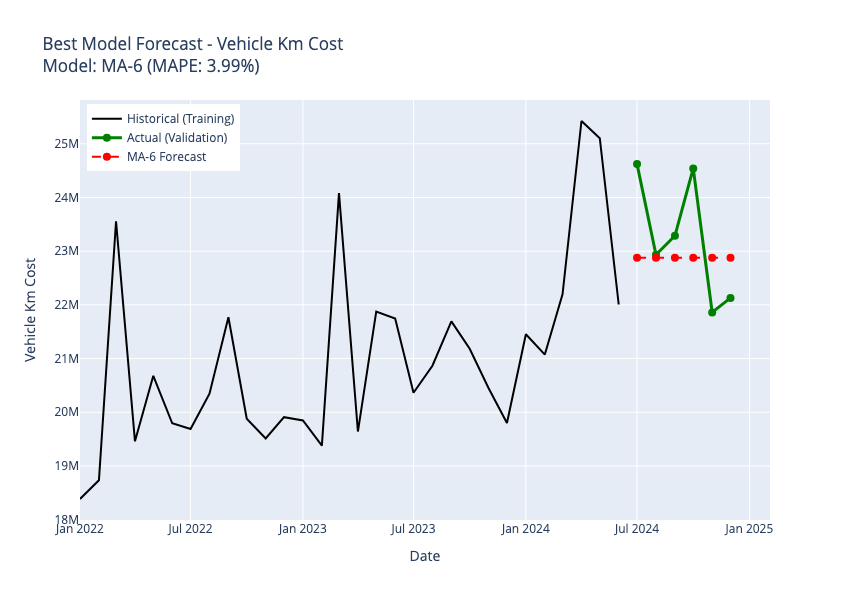

✓ Saved: results/best_model_forecast_vehicle_km_cost.html


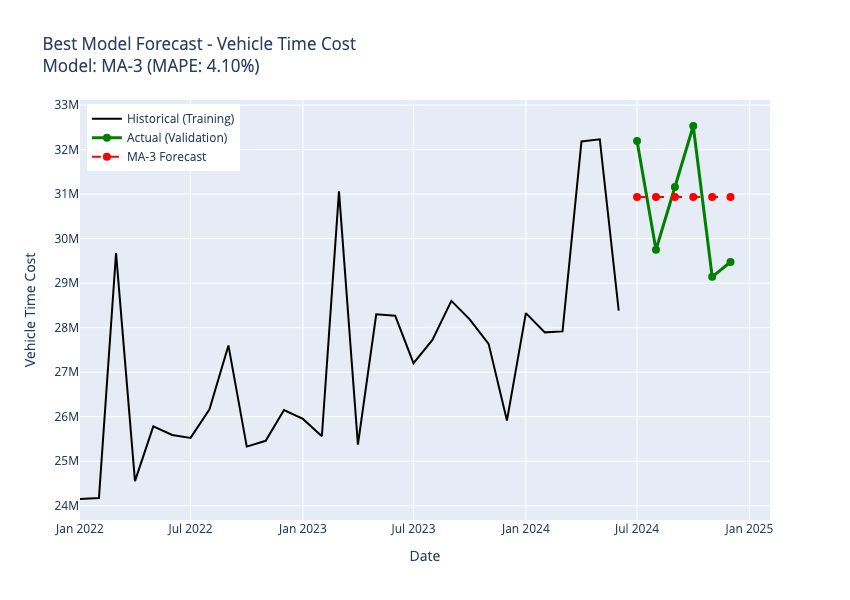

✓ Saved: results/best_model_forecast_vehicle_time_cost.html


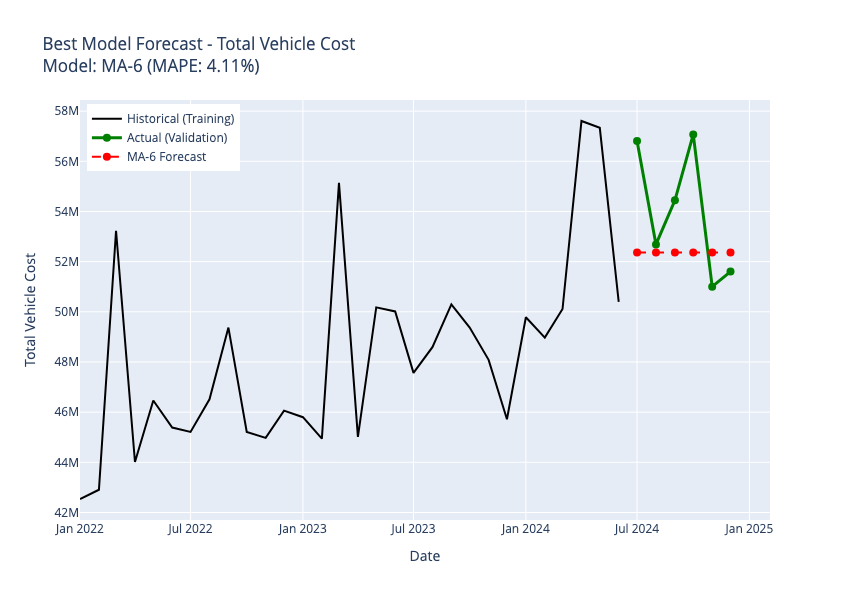

✓ Saved: results/best_model_forecast_total_vehicle_cost.html


In [7]:
# Create forecast visualization for each metric
for metric in target_metrics:
    fig = go.Figure()
    
    # Historical training data
    fig.add_trace(
        go.Scatter(
            x=train_df['date'],
            y=train_df[metric],
            mode='lines',
            name='Historical (Training)',
            line=dict(color='black', width=2)
        )
    )
    
    # Actual validation values
    if len(val_df) > 0:
        fig.add_trace(
            go.Scatter(
                x=val_df['date'],
                y=val_df[metric],
                mode='lines+markers',
                name='Actual (Validation)',
                line=dict(color='green', width=3),
                marker=dict(size=8)
            )
        )
    
    # Best model forecast
    if metric in forecasts:
        forecast_data = forecasts[metric]['data']
        model_name = forecasts[metric]['model']
        
        if 'date' in forecast_data.columns:
            forecast_data['date'] = pd.to_datetime(forecast_data['date'])
        
        if metric in forecast_data.columns:
            fig.add_trace(
                go.Scatter(
                    x=forecast_data['date'],
                    y=forecast_data[metric],
                    mode='lines+markers',
                    name=f'{model_name} Forecast',
                    line=dict(color='red', width=2, dash='dash'),
                    marker=dict(size=8)
                )
            )
    
    # Get MAPE for best model
    best_model = best_models[metric]
    mape = metrics_df[(metrics_df['metric'] == metric) & (metrics_df['model'] == best_model)]['MAPE'].values[0]
    
    fig.update_layout(
        title=f"Best Model Forecast - {metric.replace('_', ' ').title()}<br>Model: {best_model} (MAPE: {mape:.2f}%)",
        xaxis_title="Date",
        yaxis_title=metric.replace('_', ' ').title(),
        height=600,
        hovermode='x unified',
        legend=dict(x=0.01, y=0.99)
    )
    
    fig.show()
    
    # Save
    fig.write_html(results_dir / f'best_model_forecast_{metric}.html')
    print(f"✓ Saved: results/best_model_forecast_{metric}.html")

## Section 6: Generate Future Forecasts (Jul 2025 - Dec 2026)

Use best models to generate production forecasts.

In [8]:
print("Future Forecasts (Jul 2025 - Dec 2026)")
print("="*80)

future_forecasts = {}

for metric, best_model in best_models.items():
    # Determine which future forecast file to load
    if 'Prophet' in best_model:
        future_file = 'prophet_forecast_future.csv'
    elif 'SARIMAX' in best_model:
        future_file = 'sarimax_forecast_future.csv'
    else:
        print(f"⚠️  Future forecasts not available for {best_model}")
        continue
    
    future_path = metrics_dir / future_file
    
    if future_path.exists():
        df_future = pd.read_csv(future_path)
        df_future['date'] = pd.to_datetime(df_future['date'])
        
        # Filter for Jul 2025 - Dec 2026 (18 months)
        df_future = df_future[
            (df_future['date'] >= '2025-07-01') & 
            (df_future['date'] <= '2026-12-31')
        ]
        
        future_forecasts[metric] = {
            'model': best_model,
            'data': df_future
        }
        
        print(f"\n{metric} ({best_model}):")
        print(f"  Forecast period: {df_future['date'].min()} to {df_future['date'].max()}")
        print(f"  Number of months: {len(df_future)}")
        
        if metric in df_future.columns:
            print(f"  Average forecast: {df_future[metric].mean():,.0f}")
            print(f"  Min: {df_future[metric].min():,.0f}, Max: {df_future[metric].max():,.0f}")
    else:
        print(f"\n⚠️  Future forecast file not found: {future_file}")

print("\n" + "="*80)

Future Forecasts (Jul 2025 - Dec 2026)
⚠️  Future forecasts not available for XGBoost
⚠️  Future forecasts not available for XGBoost
⚠️  Future forecasts not available for MA-6
⚠️  Future forecasts not available for MA-3
⚠️  Future forecasts not available for XGBoost
⚠️  Future forecasts not available for XGBoost
⚠️  Future forecasts not available for XGBoost
⚠️  Future forecasts not available for MA-6
⚠️  Future forecasts not available for MA-3
⚠️  Future forecasts not available for MA-6



## Section 7: Save Consolidated Results

In [9]:
# Save model comparison summary
summary_df = metrics_df.groupby(['metric', 'model']).agg({
    'MAPE': 'first',
    'MAE': 'first',
    'RMSE': 'first'
}).reset_index()

summary_df = summary_df.sort_values(['metric', 'MAPE'])

summary_df.to_csv(metrics_dir / 'model_comparison_summary.csv', index=False)
print(f"✓ Saved: data/processed/model_comparison_summary.csv")

# Save best models summary
best_models_df = pd.DataFrame([
    {
        'metric': metric,
        'best_model': model,
        'mape': metrics_df[(metrics_df['metric'] == metric) & (metrics_df['model'] == model)]['MAPE'].values[0],
        'mae': metrics_df[(metrics_df['metric'] == metric) & (metrics_df['model'] == model)]['MAE'].values[0],
        'rmse': metrics_df[(metrics_df['metric'] == metric) & (metrics_df['model'] == model)]['RMSE'].values[0]
    }
    for metric, model in best_models.items()
])

best_models_df.to_csv(metrics_dir / 'best_models_summary.csv', index=False)
print(f"✓ Saved: data/processed/best_models_summary.csv")

# Consolidate future forecasts if available
if len(future_forecasts) > 0:
    # Get common dates across all metrics
    first_metric = list(future_forecasts.keys())[0]
    consolidated = future_forecasts[first_metric]['data'][['date']].copy()
    
    for metric, forecast_info in future_forecasts.items():
        if metric in forecast_info['data'].columns:
            consolidated = consolidated.merge(
                forecast_info['data'][['date', metric]],
                on='date',
                how='outer'
            )
    
    consolidated = consolidated.sort_values('date')
    consolidated.to_csv(metrics_dir / 'final_forecasts_2025_2026.csv', index=False)
    print(f"✓ Saved: data/processed/final_forecasts_2025_2026.csv")

print(f"\n{'='*80}")
print(f"MODEL COMPARISON COMPLETE!")
print(f"{'='*80}")
print(f"\nFinal Recommendations:")
for metric, model in best_models.items():
    mape = metrics_df[(metrics_df['metric'] == metric) & (metrics_df['model'] == model)]['MAPE'].values[0]
    print(f"  • {metric}: Use {model} (MAPE: {mape:.2f}%)")

print(f"\nAll results saved to:")
print(f"  • data/processed/model_comparison_summary.csv")
print(f"  • data/processed/best_models_summary.csv")
print(f"  • data/processed/final_forecasts_2025_2026.csv")
print(f"  • results/model_comparison_mape.html")
print(f"  • results/best_model_forecast_*.html (one per metric)")

✓ Saved: data/processed/model_comparison_summary.csv
✓ Saved: data/processed/best_models_summary.csv

MODEL COMPARISON COMPLETE!

Final Recommendations:
  • total_orders: Use XGBoost (MAPE: 2.50%)
  • total_km_billed: Use XGBoost (MAPE: 2.64%)
  • total_km_actual: Use MA-6 (MAPE: 3.96%)
  • total_tours: Use MA-3 (MAPE: 3.61%)
  • total_drivers: Use XGBoost (MAPE: 2.58%)
  • revenue_total: Use XGBoost (MAPE: 3.29%)
  • external_drivers: Use XGBoost (MAPE: 2.73%)
  • vehicle_km_cost: Use MA-6 (MAPE: 3.99%)
  • vehicle_time_cost: Use MA-3 (MAPE: 4.10%)
  • total_vehicle_cost: Use MA-6 (MAPE: 4.11%)

All results saved to:
  • data/processed/model_comparison_summary.csv
  • data/processed/best_models_summary.csv
  • data/processed/final_forecasts_2025_2026.csv
  • results/model_comparison_mape.html
  • results/best_model_forecast_*.html (one per metric)
